## RUL prediction using Support Vector Regression (SVR)

In this notebook, we will apply SVR to predict RUL of NASA's turbofan engine dataset FD001. We will use scikit-learn to implement SVR.

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

np.random.seed(44)

In [2]:
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Numpy version:  1.24.2
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. 

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate. 

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly. 

In [3]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [4]:
import numpy as np

def process_input_data_with_targets(input_data, target_data=None, window_length=1, shift=1):
    """Depending on values of window_length and shift, this function generates batches of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length) / shift) + 1
    
    **We don't check input dimensions using exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either an error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)
        window_length: window length of data
        shift: Distance by which the window moves for the next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
    """
    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.full((num_batches, window_length, num_features), np.nan)
    
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(0 + shift * batch):(0 + shift * batch + window_length), :]
        return output_data
    else:
        output_targets = np.full(num_batches, np.nan)
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(0 + shift * batch):(0 + shift * batch + window_length), :]
            output_targets[batch] = target_data[(shift * batch + (window_length - 1))]
        return output_data, output_targets

In [5]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [6]:
train_data = pd.read_csv("train_FD001.txt", sep= "\s+", header = None)
test_data = pd.read_csv("test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("RUL_FD001.txt", sep = "\s+", header = None)

window_length = 1
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine are taken. If set to a different number, that many windows from last are taken. 
# Final output is the average of output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (20631, 1, 14)
Processed training ruls shape:  (20631,)
Processed test data shape:  (500, 1, 14)
True RUL shape:  (100,)


In [7]:
processed_train_data = processed_train_data.reshape(-1, processed_train_data.shape[2])
processed_test_data = processed_test_data.reshape(-1, processed_test_data.shape[2])
print("Processed train data shape: ", processed_train_data.shape)
print("Processed test data shape: ", processed_test_data.shape)

Processed train data shape:  (20631, 14)
Processed test data shape:  (500, 14)


## SVR model

We will first find best set of parameters using grid search and then use those parameters to make predictions. In grid search, we first define a grid of parameters. Then for each set of parameters, we will fit a 10 SVR models (as it is 10 fold cross validation). Finally we will average the result of all folds for a particular parameter choice. The parameter choice that gives best score for cross validation is chosen as the best hyperparameter.

Grid search of hyperparameters (with cross validation) is computationally intensive. It might take a long time on a personal computer. If that is the case, readers are advised to comment the next cell and directly use the best hyperparameter values as done in subsequent cells.

In [8]:
parameters = {"C":[100],
             'epsilon':[1],
             'kernel':["rbf"]}

In [9]:
tuned_svm_reg = GridSearchCV(SVR(),parameters,n_jobs = -1, cv= 10)

In [10]:
tuned_svm_reg.fit(processed_train_data, processed_train_targets)

GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [100], 'epsilon': [1], 'kernel': ['rbf']})

### Use the following best parameters if grid search takes a long time

Using the followoing parameters, define a new model, train it, and use the trained model to make predictions. We give an example as follows.
```
best_reg_model = SVR(kernel = "rbf", C = 10, epsilon = 10)
best_reg_model.fit(processed_train_data, processed_train_targets)
rul_pred_tuned = best_reg_model.predict(processed_test_data)
```

In [11]:
tuned_svm_reg.best_params_

{'C': 100, 'epsilon': 1, 'kernel': 'rbf'}

In [12]:
best_reg_model = tuned_svm_reg.best_estimator_
best_reg_model

SVR(C=100, epsilon=1)

We will use the best model to predict on test set.

In [13]:
rul_pred_tuned = best_reg_model.predict(processed_test_data)

preds_for_each_engine_tuned = np.split(rul_pred_tuned, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine_tuned = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                                   for ruls_for_each_engine, num_windows in zip(preds_for_each_engine_tuned,
                                                                                num_test_windows_list)]
RMSE_tuned = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine_tuned))
MAE_tuned = mean_absolute_error(true_rul, mean_pred_for_each_engine_tuned)
print("RMSE after hyperparameter tuning: ", RMSE_tuned)
print("MAE after hyperparameter tuning: ", MAE_tuned)

RMSE after hyperparameter tuning:  20.674059278093875
MAE after hyperparameter tuning:  15.340921419567778


Note that while prediction, we are predicting RUL values for last 5 examples of every engine. Then we take mean of all 5 predictions for each engine and calculate final RMSE.

If instead we wish to take only the last example of every engine to make predictions and calculate RUL, we can do so by taking the last prediction of every engine as calculated before and calculate RMSE as follows.

In [14]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine_tuned)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last example): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

RMSE (Taking only last example):  19.368521476426885
MAE (Taking only last example):  14.388161939232345


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where, 

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [15]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [16]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  1421.7060080102199


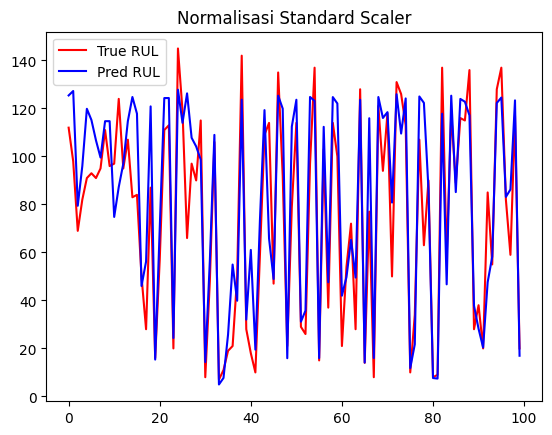

In [17]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.title("Normalisasi Standard Scaler")
plt.show()

As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open). 